# Exercise 06
# TensorFlow and Keras


**Presentado por:**
- *Angélica María Gómez Buitrago*
- *Juan Camilo Castillo Castro*

In [4]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

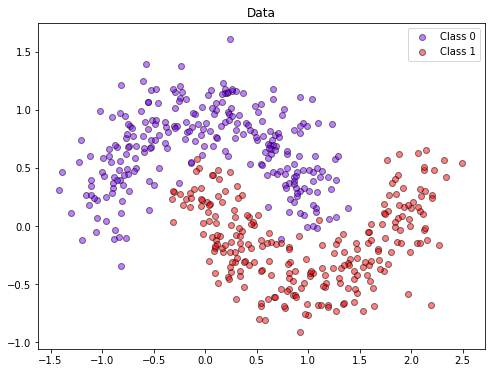

In [5]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

Se ajusta el modelo:

In [6]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline
# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
# Functions for plotting 2D data and decision regions
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [7]:
numN = 10
graph = tf.Graph()
with graph.as_default():
    #DATOS ENTRADA:
    x = tf.placeholder(tf.float32,shape=[None,2]) 
    y_true = tf.placeholder(tf.float32,shape=None) 
    with tf.name_scope('hidden_layer') as scope: 
        w_1 = tf.Variable(tf.random_normal([numN,2]),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal([numN,1]),dtype=tf.float32,name='bias1') 
        h = tf.sigmoid(tf.matmul(w_1,tf.transpose(x)) + b1, name='sigmoid')
    #MODELO INFERENCIA 
    with tf.name_scope('inference') as scope:
        w_2 = tf.Variable(tf.random_normal([1,numN]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.sigmoid(tf.matmul(w_2,h) + b )
    #FUNCION DE PERDIDA (SIGMOIDE)
    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss) 
    #FUNCION ENTRENAMIENTO
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
        train = optimizer.minimize(loss)
    init = tf.global_variables_initializer()    

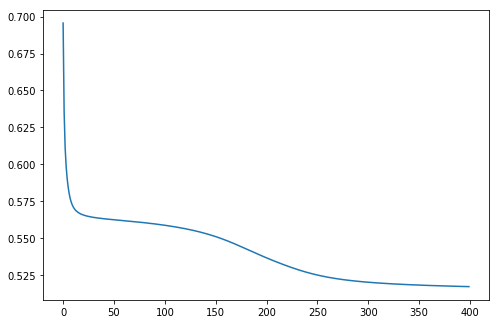

In [10]:
num_epochs = 20000
losses = []
with graph.as_default(): 
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train}) 
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train}))                    
pl.figure(figsize = (8,16/3)) 
pl.plot(losses)

[[ 1.0503857  -1.3259033 ]
 [ 0.9702814  -0.03504918]
 [-5.4981837   3.181984  ]
 [ 2.9044414  -2.446478  ]
 [ 5.242165   -2.8052692 ]
 [ 0.8454679   0.9391646 ]
 [-4.6139417   2.632662  ]
 [ 0.91515046 -0.8850139 ]
 [-7.569531   -6.500821  ]
 [ 1.735967    2.4960005 ]]
[[1.0267243e-05]]


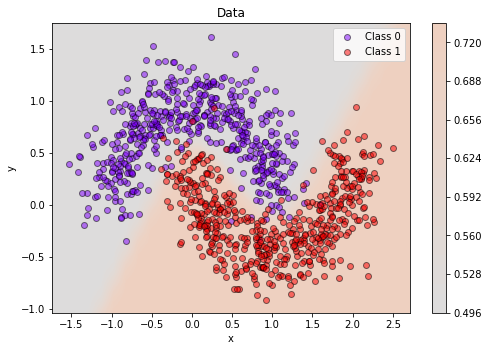

In [11]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))
with graph.as_default():
    wval = sess.run(w_1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])}) 
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))
pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


### 2. Training a text classifier

In [36]:
import numpy as np
import pylab as pl
import keras
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')


Loading data...
8982 train sequences
2246 test sequences
46 classes


Is instance is represented by a sequence of numbers which correspond to indices of the corresponding words.

In [37]:
print(x_train[101])

[1, 2, 149, 8, 25, 2, 400, 304, 200, 6, 337, 4, 342, 2, 2, 7, 2, 2, 9, 4, 342, 643, 2, 7, 2, 4, 88, 2, 31, 4, 384, 292, 211, 5, 2, 978, 220, 33, 851, 2, 11, 15, 9, 447, 7, 42, 92, 131, 276, 5, 156, 11, 15, 50, 33, 30, 2, 7, 2, 383, 29, 336, 25, 383, 29, 2, 94, 156, 4, 49, 8, 7, 788, 4, 88, 33, 2, 747, 11, 15, 197, 92, 222, 825, 5, 934, 11, 15, 2, 8, 17, 12]


The map for word to index is also provided, so it is possible to decode the instance back to text:

In [38]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


Data is encoded using a bag of words representation, i.e. a matrix of size num of instances by vocabulary size

In [39]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


Labels are converted to one-hot representation:

In [40]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


Now we build a dense neural network with one hidden layer:

In [41]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_9 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_9 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_10 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_10 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


We configure the learning task to use SGD as optimization:

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


Now we can train the model using a 0.1 training validation split:

In [43]:
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 208us/step - loss: 2.4542 - acc: 0.3630 - val_loss: 2.3069 - val_acc: 0.4260
Epoch 2/5
8083/8083 [==============================] - 1s 173us/step - loss: 2.1809 - acc: 0.4397 - val_loss: 2.1788 - val_acc: 0.4750
Epoch 3/5
8083/8083 [==============================] - 1s 171us/step - loss: 2.0693 - acc: 0.4876 - val_loss: 2.0863 - val_acc: 0.4905
Epoch 4/5
8083/8083 [==============================] - 1s 168us/step - loss: 1.9903 - acc: 0.5032 - val_loss: 2.0180 - val_acc: 0.5061
Epoch 5/5
8083/8083 [==============================] - 1s 168us/step - loss: 1.9276 - acc: 0.5163 - val_loss: 1.9608 - val_acc: 0.5150


Finally, we test the performance over the test set:

In [44]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 76us/step
Test score: 1.926466398969465
Test accuracy: 0.5258236865804117


## Different activation functions for the hidden layer

 **1.** Activation Function: **relu**

In [53]:
model1 = Sequential()
model1.add(Dense(256, input_shape=(max_words,)))
model1.add(Activation('relu'))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))
model1.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_15 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_15 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_16 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_16 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [54]:
model1.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [55]:
batch_size = 32
epochs = 5
history = model1.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 220us/step - loss: 2.4206 - acc: 0.4554 - val_loss: 1.9579 - val_acc: 0.5106
Epoch 2/5
8083/8083 [==============================] - 1s 166us/step - loss: 1.7845 - acc: 0.5530 - val_loss: 1.7445 - val_acc: 0.5806
Epoch 3/5
8083/8083 [==============================] - 1s 163us/step - loss: 1.6152 - acc: 0.6150 - val_loss: 1.6210 - val_acc: 0.6296
Epoch 4/5
8083/8083 [==============================] - 1s 171us/step - loss: 1.4976 - acc: 0.6550 - val_loss: 1.5354 - val_acc: 0.6663
Epoch 5/5
8083/8083 [==============================] - 1s 161us/step - loss: 1.4030 - acc: 0.6861 - val_loss: 1.4652 - val_acc: 0.6830


In [56]:
score = model1.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 70us/step
Test score: 1.4597950058119273
Test accuracy: 0.674532502252718


**2.** Activation Function: **tanh**

In [57]:
model2 = Sequential()
model2.add(Dense(256, input_shape=(max_words,)))
model2.add(Activation('tanh'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))
model2.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_17 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_17 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_18 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_18 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [58]:
model2.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [59]:
batch_size = 32
epochs = 5
history = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 231us/step - loss: 2.2195 - acc: 0.4814 - val_loss: 1.8530 - val_acc: 0.5517
Epoch 2/5
8083/8083 [==============================] - 1s 167us/step - loss: 1.6774 - acc: 0.6018 - val_loss: 1.6559 - val_acc: 0.6196
Epoch 3/5
8083/8083 [==============================] - 1s 172us/step - loss: 1.5133 - acc: 0.6552 - val_loss: 1.5425 - val_acc: 0.6518
Epoch 4/5
8083/8083 [==============================] - 1s 166us/step - loss: 1.4021 - acc: 0.6820 - val_loss: 1.4614 - val_acc: 0.6796
Epoch 5/5
8083/8083 [==============================] - 1s 168us/step - loss: 1.3181 - acc: 0.7053 - val_loss: 1.4059 - val_acc: 0.6941


In [60]:
score = model2.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 75us/step
Test score: 1.3851715947301495
Test accuracy: 0.6954585930808569


**3.** Activation Function: **selu**

In [61]:
model3 = Sequential()
model3.add(Dense(256, input_shape=(max_words,)))
model3.add(Activation('selu'))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))
model3.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_19 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_19 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_20 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_20 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [62]:
model3.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [63]:
batch_size = 32
epochs = 5
history = model3.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 229us/step - loss: 2.0339 - acc: 0.5351 - val_loss: 1.7226 - val_acc: 0.5840
Epoch 2/5
8083/8083 [==============================] - 1s 180us/step - loss: 1.5225 - acc: 0.6454 - val_loss: 1.5399 - val_acc: 0.6641
Epoch 3/5
8083/8083 [==============================] - 1s 173us/step - loss: 1.3564 - acc: 0.6928 - val_loss: 1.4326 - val_acc: 0.6874
Epoch 4/5
8083/8083 [==============================] - 1s 171us/step - loss: 1.2443 - acc: 0.7250 - val_loss: 1.3607 - val_acc: 0.7030
Epoch 5/5
8083/8083 [==============================] - 1s 175us/step - loss: 1.1598 - acc: 0.7454 - val_loss: 1.3066 - val_acc: 0.7186


In [64]:
score = model3.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 79us/step
Test score: 1.2658956292900567
Test accuracy: 0.7239536954851312


**Conclusión**: La función de activación en la capa oculta que da mejores resultados en cuanto accuracy es la "selu".

## Different optimizers

**1.** Optimizador **Adam**

In [65]:
model4 = Sequential()
model4.add(Dense(256, input_shape=(max_words,)))
model4.add(Activation('sigmoid'))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))
model4.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_21 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_21 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_22 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_22 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [66]:
model4.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])


Now we can train the model using a 0.1 training validation split:

In [67]:
batch_size = 32
epochs = 5
history = model4.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 343us/step - loss: 1.6091 - acc: 0.6244 - val_loss: 1.2970 - val_acc: 0.7119
Epoch 2/5
8083/8083 [==============================] - 2s 284us/step - loss: 1.0290 - acc: 0.7747 - val_loss: 1.0751 - val_acc: 0.7642
Epoch 3/5
8083/8083 [==============================] - 2s 286us/step - loss: 0.8134 - acc: 0.8127 - val_loss: 0.9890 - val_acc: 0.7898
Epoch 4/5
8083/8083 [==============================] - 2s 282us/step - loss: 0.6718 - acc: 0.8434 - val_loss: 0.9308 - val_acc: 0.8009
Epoch 5/5
8083/8083 [==============================] - 2s 295us/step - loss: 0.5624 - acc: 0.8724 - val_loss: 0.8957 - val_acc: 0.8009


Finally, we test the performance over the test set:

In [68]:
score = model4.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 68us/step
Test score: 0.8714403369441589
Test accuracy: 0.7907390917186109


**2.** Optimizador **RMSprop**

In [69]:
model5 = Sequential()
model5.add(Dense(256, input_shape=(max_words,)))
model5.add(Activation('sigmoid'))
model5.add(Dense(num_classes))
model5.add(Activation('softmax'))
model5.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_23 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_23 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_24 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_24 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [73]:
model5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [74]:
batch_size = 32
epochs = 5
history = model5.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 297us/step - loss: 1.5393 - acc: 0.6527 - val_loss: 1.2833 - val_acc: 0.7319
Epoch 2/5
8083/8083 [==============================] - 2s 251us/step - loss: 1.0222 - acc: 0.7763 - val_loss: 1.0986 - val_acc: 0.7575
Epoch 3/5
8083/8083 [==============================] - 2s 229us/step - loss: 0.8176 - acc: 0.8147 - val_loss: 1.0136 - val_acc: 0.7742
Epoch 4/5
8083/8083 [==============================] - 2s 229us/step - loss: 0.6873 - acc: 0.8440 - val_loss: 0.9441 - val_acc: 0.7909
Epoch 5/5
8083/8083 [==============================] - 2s 231us/step - loss: 0.5872 - acc: 0.8645 - val_loss: 0.9265 - val_acc: 0.7920


In [76]:
score = model5.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 69us/step
Test score: 0.8788462511047336
Test accuracy: 0.7943009795191451


**3.** Optimizador **Adadelta**

In [77]:
model6 = Sequential()
model6.add(Dense(256, input_shape=(max_words,)))
model6.add(Activation('sigmoid'))
model6.add(Dense(num_classes))
model6.add(Activation('softmax'))
model6.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_25 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_25 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_26 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_26 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [82]:
model6.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

batch_size = 32
epochs = 5
history = model6.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 285us/step - loss: 1.3748 - acc: 0.6891 - val_loss: 1.2290 - val_acc: 0.7319
Epoch 2/5
8083/8083 [==============================] - 2s 230us/step - loss: 1.0006 - acc: 0.7802 - val_loss: 1.1272 - val_acc: 0.7519
Epoch 3/5
8083/8083 [==============================] - 2s 229us/step - loss: 0.8770 - acc: 0.8048 - val_loss: 1.0588 - val_acc: 0.7664
Epoch 4/5
8083/8083 [==============================] - 2s 235us/step - loss: 0.7993 - acc: 0.8190 - val_loss: 1.0257 - val_acc: 0.7742
Epoch 5/5
8083/8083 [==============================] - 2s 232us/step - loss: 0.7413 - acc: 0.8311 - val_loss: 0.9933 - val_acc: 0.7809


In [83]:
score = model6.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 78us/step
Test score: 0.9610738866794141
Test accuracy: 0.7702582368920768


**Conclusión**: El optimizador que da mejores resultados en cuanto accuracy en los datos de test es el RMSprop.

## Add dropout between the hidden layer and the output layer

In [96]:
model7 = Sequential()
model7.add(Dense(256, input_shape=(max_words,)))
model7.add(Activation('sigmoid'))
model7.add(Dropout(0.5, noise_shape=None, seed=42))
model7.add(Dense(num_classes))
model7.add(Activation('softmax'))
model7.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_35 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_35 (Activation)     (None, 256)                 0          
______________________________________________________________________
dropout_5 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_36 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_36 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [97]:
model7.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model7.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 256us/step - loss: 2.6264 - acc: 0.3449 - val_loss: 2.3375 - val_acc: 0.3370
Epoch 2/5
8083/8083 [==============================] - 2s 188us/step - loss: 2.3536 - acc: 0.4002 - val_loss: 2.2359 - val_acc: 0.3726
Epoch 3/5
8083/8083 [==============================] - 2s 187us/step - loss: 2.2702 - acc: 0.4164 - val_loss: 2.1538 - val_acc: 0.4605
Epoch 4/5
8083/8083 [==============================] - 1s 185us/step - loss: 2.1856 - acc: 0.4419 - val_loss: 2.0841 - val_acc: 0.4894
Epoch 5/5
8083/8083 [==============================] - 1s 185us/step - loss: 2.1399 - acc: 0.4610 - val_loss: 2.0341 - val_acc: 0.4905


In [98]:
score = model7.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 79us/step
Test score: 1.9891650795618128
Test accuracy: 0.5111308994032078


**Conclusión**: Agregar dropout de 0.5 deteriora ligeramente el accuracy frente al modelo inicial, pero puede generar eficiencias computacionales.

## Different initializers for the dense layers

**1.** Initializer **'random_uniform' + 'zeros'**

In [101]:
model8 = Sequential()
model8.add(Dense(256, input_shape=(max_words,), kernel_initializer='random_uniform',
                bias_initializer='zeros'))
model8.add(Activation('sigmoid'))
model8.add(Dense(num_classes))
model8.add(Activation('softmax'))
model8.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_41 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_41 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_42 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_42 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [102]:
model8.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model8.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 248us/step - loss: 2.4277 - acc: 0.3497 - val_loss: 2.3109 - val_acc: 0.3749
Epoch 2/5
8083/8083 [==============================] - 1s 169us/step - loss: 2.1858 - acc: 0.4204 - val_loss: 2.1851 - val_acc: 0.4349
Epoch 3/5
8083/8083 [==============================] - 1s 175us/step - loss: 2.0735 - acc: 0.4742 - val_loss: 2.0907 - val_acc: 0.4772
Epoch 4/5
8083/8083 [==============================] - 1s 171us/step - loss: 1.9914 - acc: 0.4986 - val_loss: 2.0176 - val_acc: 0.5050
Epoch 5/5
8083/8083 [==============================] - 1s 174us/step - loss: 1.9270 - acc: 0.5122 - val_loss: 1.9595 - val_acc: 0.5128


In [103]:
score = model8.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 81us/step
Test score: 1.9175044422370455
Test accuracy: 0.5280498664557456


**2.** Initializer **'TruncatedNormal'**

In [105]:
model9 = Sequential()
model9.add(Dense(256, input_shape=(max_words,), kernel_initializer='TruncatedNormal'))
model9.add(Activation('sigmoid'))
model9.add(Dense(num_classes))
model9.add(Activation('softmax'))
model9.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_45 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_45 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_46 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_46 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [106]:
model9.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model9.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 254us/step - loss: 2.4216 - acc: 0.3583 - val_loss: 2.3080 - val_acc: 0.3782
Epoch 2/5
8083/8083 [==============================] - 1s 178us/step - loss: 2.1792 - acc: 0.4419 - val_loss: 2.1768 - val_acc: 0.4872
Epoch 3/5
8083/8083 [==============================] - 1s 172us/step - loss: 2.0657 - acc: 0.4928 - val_loss: 2.0883 - val_acc: 0.4772
Epoch 4/5
8083/8083 [==============================] - 1s 175us/step - loss: 1.9850 - acc: 0.5059 - val_loss: 2.0080 - val_acc: 0.5106
Epoch 5/5
8083/8083 [==============================] - 1s 171us/step - loss: 1.9215 - acc: 0.5182 - val_loss: 1.9528 - val_acc: 0.5139


In [107]:
score = model9.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 72us/step
Test score: 1.9227466821033616
Test accuracy: 0.5298308103560128


**Conclusión**: El accuracy mejora al agregar diferentes initializers, siendo el mejor caso utilizar 'TruncatedNormal'.

## Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?

Probaremos el modelo utilizando las opciones en las que se obtuvieron los mejores valores de accuracy para cada parámetro. En el primer caso usando dropout (0.5) y en el segundo caso sin dropout. Esto es:

- Función de activación:'selu'
- Optimizador: 'RMSprop'
- Inizialiter:'TruncatedNormal'

In [112]:
model11 = Sequential()
model11.add(Dense(256, input_shape=(max_words,), kernel_initializer='TruncatedNormal'))
model11.add(Activation('selu'))
model11.add(Dropout(0.5, noise_shape=None, seed=42))
model11.add(Dense(num_classes))
model11.add(Activation('softmax'))
model11.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_49 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_49 (Activation)     (None, 256)                 0          
______________________________________________________________________
dropout_7 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_50 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_50 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [113]:
model11.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model11.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 349us/step - loss: 1.3346 - acc: 0.7088 - val_loss: 1.0547 - val_acc: 0.7775
Epoch 2/5
8083/8083 [==============================] - 2s 253us/step - loss: 0.8182 - acc: 0.8153 - val_loss: 0.9563 - val_acc: 0.8042
Epoch 3/5
8083/8083 [==============================] - 2s 254us/step - loss: 0.6372 - acc: 0.8554 - val_loss: 0.9350 - val_acc: 0.8053
Epoch 4/5
8083/8083 [==============================] - 2s 265us/step - loss: 0.5436 - acc: 0.8758 - val_loss: 0.9503 - val_acc: 0.7964
Epoch 5/5
8083/8083 [==============================] - 2s 256us/step - loss: 0.4883 - acc: 0.8880 - val_loss: 0.9413 - val_acc: 0.8020


In [114]:
score = model11.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 89us/step
Test score: 0.9203224275543131
Test accuracy: 0.7996438112199465


Ahora sin dropout:

In [115]:
model12 = Sequential()
model12.add(Dense(256, input_shape=(max_words,), kernel_initializer='TruncatedNormal'))
model12.add(Activation('selu'))
model12.add(Dense(num_classes))
model12.add(Activation('softmax'))
model12.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_51 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_51 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_52 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_52 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [116]:
model12.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


batch_size = 32
epochs = 5
history = model12.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 3s 382us/step - loss: 1.1700 - acc: 0.7383 - val_loss: 1.0175 - val_acc: 0.7820
Epoch 2/5
8083/8083 [==============================] - 2s 284us/step - loss: 0.6254 - acc: 0.8590 - val_loss: 0.9018 - val_acc: 0.8031
Epoch 3/5
8083/8083 [==============================] - 2s 277us/step - loss: 0.4506 - acc: 0.8927 - val_loss: 0.9190 - val_acc: 0.8009
Epoch 4/5
8083/8083 [==============================] - 2s 288us/step - loss: 0.3585 - acc: 0.9177 - val_loss: 0.9773 - val_acc: 0.7998
Epoch 5/5
8083/8083 [==============================] - 2s 266us/step - loss: 0.3039 - acc: 0.9287 - val_loss: 1.0432 - val_acc: 0.7931


In [117]:
score = model12.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 76us/step
Test score: 1.023211279407953
Test accuracy: 0.7813891362422084


### Conclusión: El mejor modelo resulta ser el que tiene función de activación 'selu', optimizador: 'RMSprop', inizialiter 'TruncatedNormal' y dropout de 0.5 lo que da un accuracy 0.7996 que es superior al de todos los modelos analizados.